# EfficientAD

Bu notebook, MVTec AD veri setinin "wood" alt kümesi üzerinde EfficientAD mimarisi kullanılarak anomalilerin tespiti ve segmentasyonu amacıyla model eğitimi ve değerlendirme sürecini içermektedir.









## 1. Ortam Kurulumu

### 1.1 Google Drive Bağlantısı  
Eğitim ve test verilerine erişim sağlamak için Google Drive bağlanır.


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


### 1.2 EfficientAD için Depo Klonlanması  
EfficientAD modeline ait kaynak kodlar GitHub üzerinden klonlanarak çalışma ortamına dahil edilir.


In [12]:
!git clone https://github.com/gmzdag/wood-anomaly-detection.git

Cloning into 'wood-anomaly-detection'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 64 (delta 5), reused 63 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (64/64), 40.81 MiB | 30.53 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [3]:
!git pull

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [4]:
%cd /content/drive/MyDrive/wood-anomaly-detection/models/EfficientAD/src

/content/drive/MyDrive/wood-anomaly-detection/models/EfficientAD/src


## 2. Model Eğitimi  
EfficientAD mimarisi, "wood" sınıfı üzerinde eğitim parametreleriyle birlikte eğitilir.


--mvtec_ad_path: Ön işlenmiş MVTec AD veri setinin bulunduğu klasör yolu.

--weights: Başlangıç ağırlıklarını içeren teacher model dosyası (.pth).

--output_dir: Eğitim çıktılarının (örneğin anomaly map'ler) kaydedileceği klasör.

--subdataset: Kullanılacak alt veri kümesi (wood).

--model_size: EfficientAD modelinin boyutu (medium, small, vb.).

--imagenet_train_path: Görüntü ön eğitim verisi kullanılmadığı için "none" olarak verilmiştir.

--train_steps: Eğitim sırasında gerçekleştirilecek toplam adım sayısı (örneğin 20000 adım = yaklaşık 20 dakikalık eğitim süresi sınırı).

Bu komut, EfficientAD mimarisiyle anomaly detection modeli eğitir ve çıktı sonuçlarını belirlenen dizine kaydeder.

In [5]:
!python /content/drive/MyDrive/wood-anomaly-detection/models/EfficientAD/src/efficientad.py \
  --mvtec_ad_path '/content/drive/MyDrive/processed_dataset' \
  --weights '/content/drive/MyDrive/wood-anomaly-detection/models/EfficientAD/src/models/teacher_medium.pth' \
  --output_dir '/content/drive/MyDrive/outputs/efficient' \
  --subdataset wood \
  --model_size medium \
  --imagenet_train_path none \
  --train_steps 20000

Computing mean of features: 100% 63/63 [00:13<00:00,  4.60it/s]
Computing std of features: 100% 63/63 [00:00<00:00, 156.88it/s]
Current loss: 7.3504:  50% 10000/20000 [04:43<03:58, 41.92it/s]
Intermediate map normalization: 100% 7/7 [00:00<00:00, 71.21it/s]

Intermediate inference:   0% 0/141 [00:00<?, ?it/s]
Intermediate inference:   1% 1/141 [00:00<01:54,  1.23it/s]
Intermediate inference:   1% 2/141 [00:01<01:48,  1.29it/s]
Intermediate inference:   2% 3/141 [00:02<01:37,  1.42it/s]
Current loss: 7.3504:  50% 10000/20000 [04:59<03:58, 41.92it/s]
Intermediate inference:   4% 5/141 [00:04<01:52,  1.21it/s]
Intermediate inference:   4% 6/141 [00:04<01:48,  1.24it/s]
Intermediate inference:   5% 7/141 [00:05<01:45,  1.27it/s]
Intermediate inference:   6% 8/141 [00:06<01:36,  1.38it/s]
Intermediate inference:   6% 9/141 [00:06<01:36,  1.36it/s]
Intermediate inference:   7% 10/141 [00:07<01:38,  1.34it/s]
Intermediate inference:   8% 11/141 [00:08<01:35,  1.36it/s]
Intermediate inference:

## Anomaly Detection Sonuçları

EfficientAD modeli ile yapılan anomaly detection eğitimi sonrası elde edilen test sonuçları aşağıdaki gibidir:

| Metrik              | Değer   |
|---------------------|---------|
| **AUC Score**       | 0.9584  |
| **F1 Score**        | 0.9324  |
| **Precision**       | 0.8961  |
| **Recall**          | 0.9718  |
| **Seçilen Threshold** | 0.4053 |

### Açıklamalar:

- **AUC (Area Under Curve)**: Modelin genel ayırt edicilik başarısı. 1’e ne kadar yakınsa, model o kadar iyi sınıflandırma yapar.
- **F1 Score**: Precision ve Recall’un harmonik ortalamasıdır. Anomalileri hem doğru tespit etme (recall) hem de hatalı etiketlememe (precision) dengesini gösterir.
- **Precision**: Modelin "anomali" dediği görüntülerin ne kadarının gerçekten anomalili olduğu.
- **Recall**: Gerçek anomalilerin ne kadarını doğru bulabildiği.
- **Selected Threshold**: Anomaly map’lerin ikili sınıflamaya çevrildiği en iyi eşik değeri (F1 skoru en yüksek yapan threshold).

Bu metrikler, modelin yüksek doğruluk ve hassasiyetle çalıştığını ve gerçek dünyada kullanılabilecek kadar iyi bir anomaly detector olduğunu göstermektedir.


##Threshold Tabanlı IoU Optimizasyonu

Bu hücrede, test verileri üzerinde modelin segmentasyon başarımını ölçmek için **Intersection over Union (IoU)** metriği kullanılmıştır. Amaç, anomaly map’leri binarize etmek için en uygun threshold değerini belirlemektir.


In [7]:
import os
import numpy as np
import tifffile
import cv2
from glob import glob
from sklearn.metrics import jaccard_score

pred_mask_dir = '/content/drive/MyDrive/outputs/efficient/anomaly_maps/mvtec_ad/wood/test/defect'
gt_mask_dir = '/content/drive/MyDrive/processed_dataset/wood/ground_truth/defect/'

thresholds = np.linspace(0.01, 0.5, 50)
best_iou = 0
best_thresh = 0

for thresh in thresholds:
    ious = []
    for pred_path in sorted(glob(os.path.join(pred_mask_dir, '*.tiff'))):
        file_id = os.path.splitext(os.path.basename(pred_path))[0]
        gt_path = os.path.join(gt_mask_dir, f"{file_id}_mask.jpg")

        if not os.path.exists(gt_path):
            continue

        pred_mask = tifffile.imread(pred_path)
        gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

        pred_bin = (pred_mask > thresh).astype(np.uint8)
        gt_bin = (gt_mask > 0).astype(np.uint8)

        iou = jaccard_score(gt_bin.flatten(), pred_bin.flatten())
        ious.append(iou)

    if ious:  # boş kalırsa np.mean hata verir
        mean_iou = np.mean(ious)
        if mean_iou > best_iou:
            best_iou = mean_iou
            best_thresh = thresh

print(f"En iyi threshold (IoU'ya göre): {best_thresh:.4f} | Ortalama IoU: {best_iou:.4f}")


En iyi threshold (IoU'ya göre): 0.1700 | Ortalama IoU: 0.2718


##Tahmin ve Ground Truth Karşılaştırması (Görselleştirme)

Aşağıdaki kod bloğu, eğitim sonrası modelin test verisi üzerinde yaptığı tahminleri, binarize maskeleri ve ground truth maskeleri ile birlikte karşılaştırmalı olarak görselleştirir.


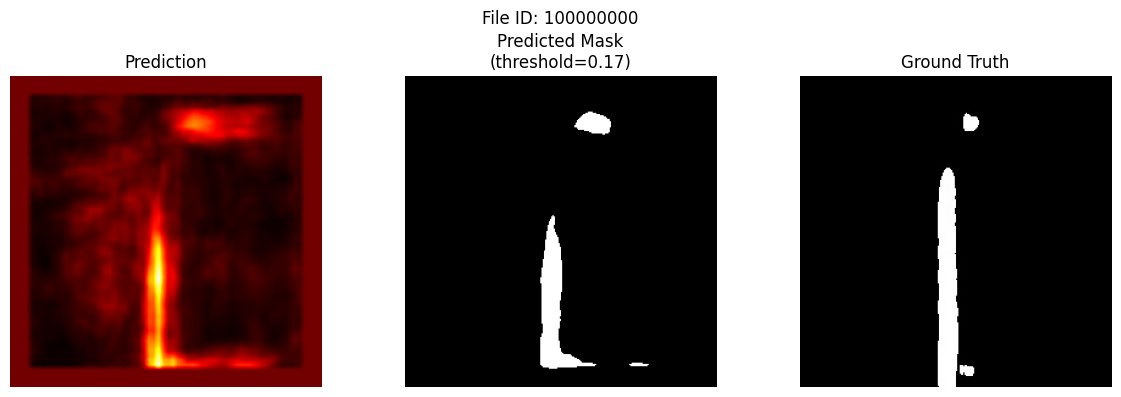

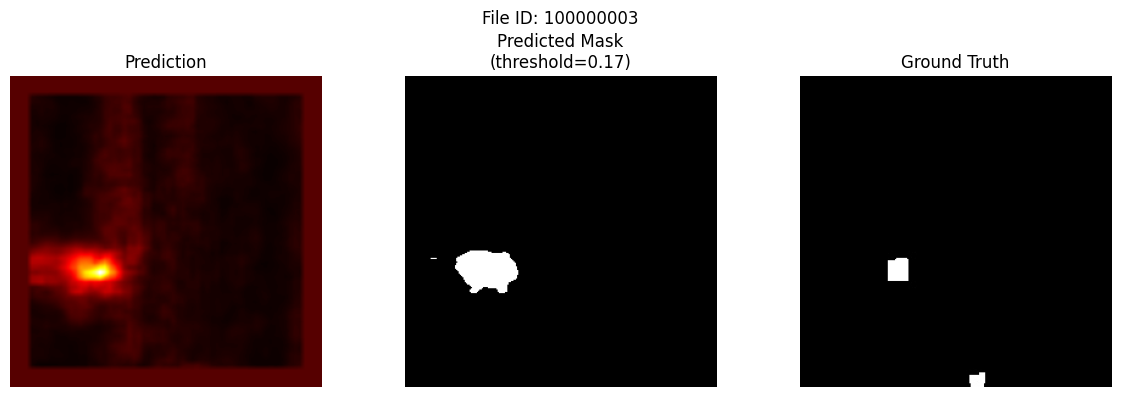

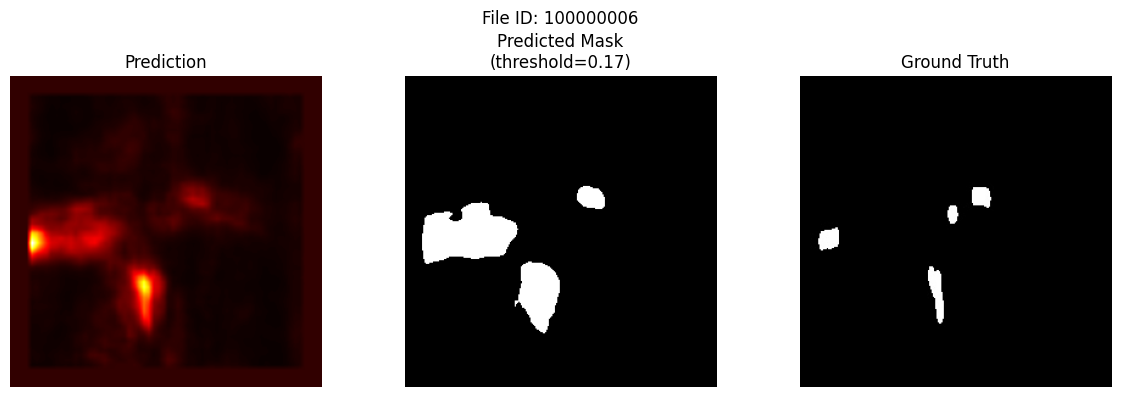

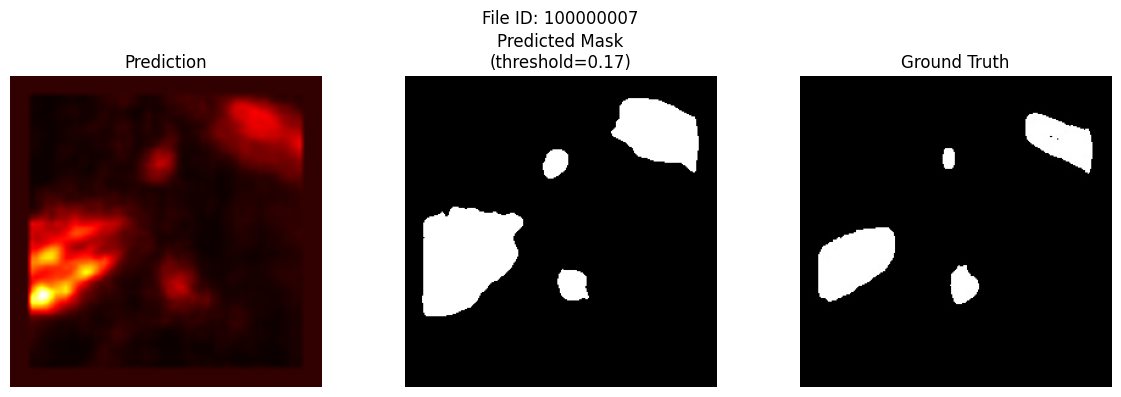

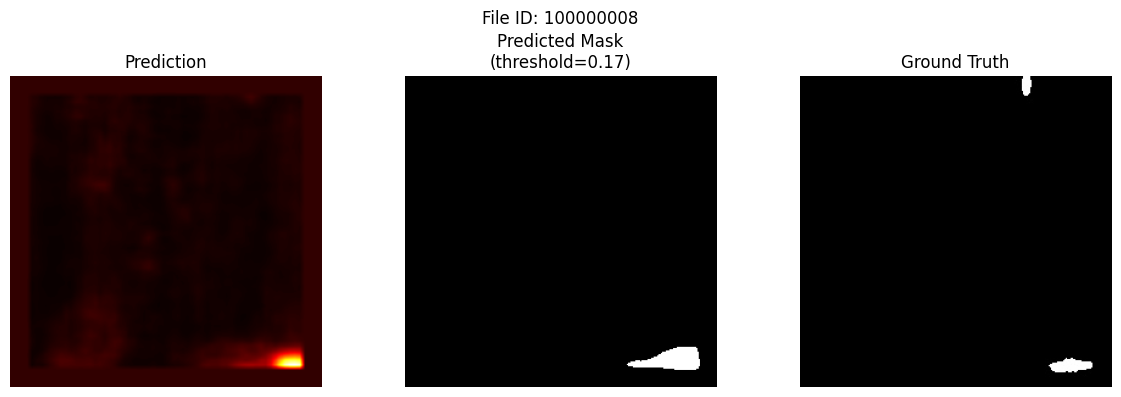

In [8]:
import os
import cv2
import tifffile
import matplotlib.pyplot as plt
from glob import glob

# Dosya yolları
pred_paths = sorted(glob(os.path.join(pred_mask_dir, "*.tiff")))

threshold = 0.17  # IoU için en iyi bulunan threshold

for i in range(5):
    pred_path = pred_paths[i]
    file_id = os.path.splitext(os.path.basename(pred_path))[0]
    gt_path = os.path.join(gt_mask_dir, f"{file_id}_mask.jpg")

    if not os.path.exists(gt_path):
        print(f"❌ Ground truth eksik: {file_id}_mask.jpg")
        continue

    # Maske yükle
    pred_mask = tifffile.imread(pred_path)
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

    pred_mask = cv2.resize(pred_mask, (256, 256))
    gt_mask = cv2.resize(gt_mask, (256, 256))

    # Binary maskeye çevir
    pred_bin = (pred_mask > threshold).astype(np.uint8)

    # Görselleştir
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Prediction")
    plt.imshow(pred_mask, cmap='hot')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"Predicted Mask\n(threshold={threshold:.2f})")
    plt.imshow(pred_bin, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Ground Truth")
    plt.imshow(gt_mask, cmap='gray')
    plt.axis('off')

    plt.suptitle(f"File ID: {file_id}")
    plt.tight_layout()
    plt.show()
